In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.utils import resample

figure_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN/Figures/'
result_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN/ModelAnalysis/'
evaluation_path = '/Users/lynnsorensen/surfdrive/SpatialAttention_sDCNN/ModelEvaluation/'
save = False

tracker = joblib.load(result_path + 'EvokedPotentials_020720.pkl')
colors = sns.color_palette(sns.xkcd_palette(["orange yellow","windows blue", "greyish", "faded green", "dusty purple","orange", "grey"]))

offset = 0
l = 25
onset = 100
time_steps = np.arange(-onset, tracker[l]['neutral']['evoked'].shape[1] - onset)
n = tracker[l]['neutral']['evoked'].shape[0]
features = 256
conds = ['P-1_I-0_O-0.3','P-0_I-0_O-0.3','P-1_I-0.15_O-0','P-0_I-0.15_O-0','P-1_I-0.05_O-0.2','P-0_I-0.05_O-0.2', 'P-1_I-0_O-0']


evo_avgs = pd.DataFrame(np.zeros((len(conds) * 3 * n,3)), columns=['Model', 'Attention', 'Potential'])
evo_avgs['Image'] = np.repeat(np.arange(n)[np.newaxis,:],3 *len(conds), axis=0).flatten()
evo_avgs['Attention'] = np.repeat(np.arange(3)[np.newaxis,:],n *len(conds), axis=0).flatten()
evo_avgs['Model'] = np.repeat(np.arange(len(conds))[np.newaxis,:],n *3, axis=0).flatten()

replace_map = {'Attention': {0: 'valid', 1:'neutral', 2:'invalid'},
               'Model': {0: conds[0], 1: conds[1], 2: conds[2], 3: conds[3], 4: conds[4], 5: conds[5], 6: conds[6]}}
evo_avgs.replace(replace_map, inplace=True)


num_draws = 500
resp = tracker[l]['neutral']['evoked'][:n, offset:]
idx = np.arange(resp.shape[0])
mean_draws_neutral = list()
for d in range(num_draws):
    # Resampling, with replacement
    draw = resample(idx, random_state=d)
    mean_draws_neutral.append(np.mean(resp[draw], axis=0))



P-1_I-0_O-0.3


P-0_I-0_O-0.3


P-1_I-0.15_O-0


P-0_I-0.15_O-0


P-1_I-0.05_O-0.2


P-0_I-0.05_O-0.2


P-1_I-0_O-0


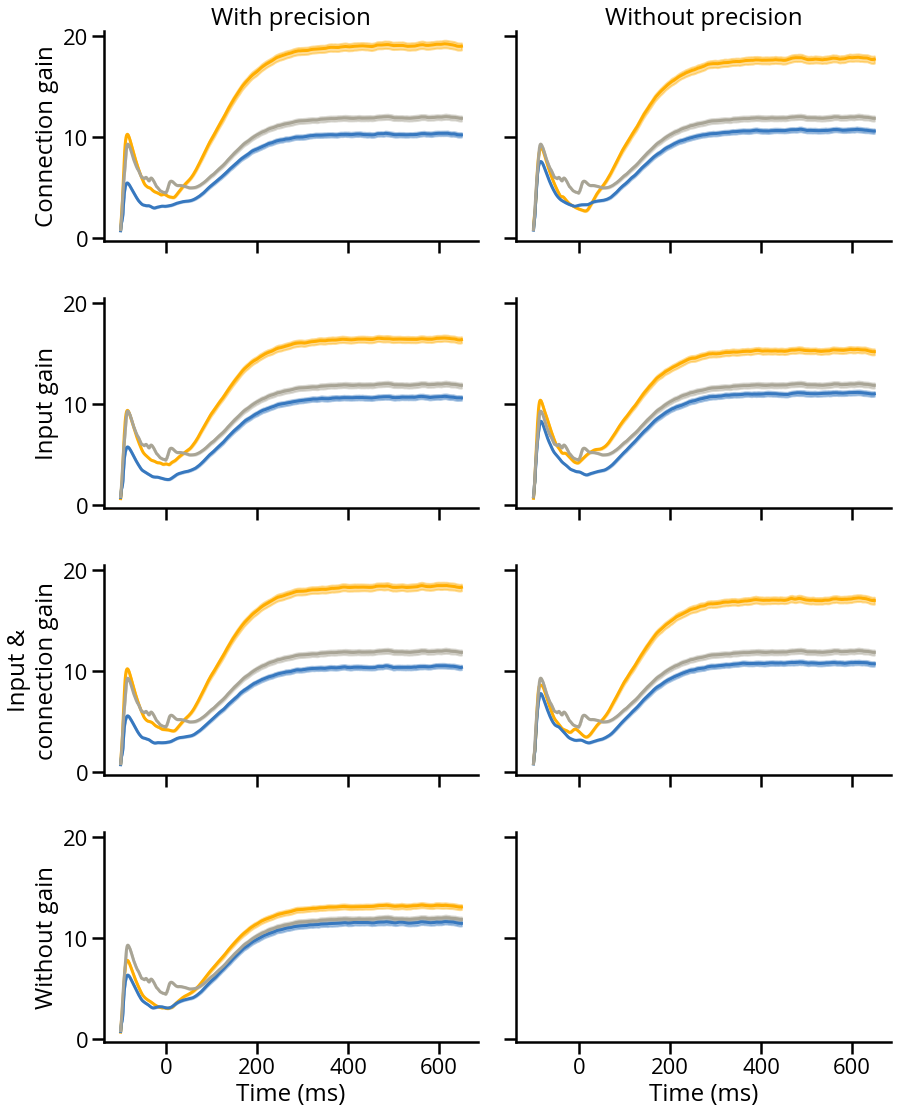

In [2]:
sns.set_context("poster")
fig, ax = plt.subplots(4,2, figsize=(13, 16), sharey=True, sharex=True)
ax = ax.flatten()

for c, cond in enumerate(conds):
    for a, att in enumerate(['valid', 'invalid', 'neutral']):
        if att == 'neutral':
            resp = tracker[l][att]['evoked'][:n, offset:]
            mean_draws = mean_draws_neutral

        else:
            resp = tracker[l][cond][att]['evoked'][:n, offset:]

            mean_draws = list()
            for d in range(num_draws):
                # Resampling, with replacement, taking the class imbalance into account
                draw = resample(idx, random_state=d)
                mean_draws.append(np.mean(resp[draw], axis=0))

        ax[c].plot(time_steps,np.mean(resp, axis=0), color=colors[a])

        ax[c].fill_between(time_steps, np.percentile(np.array(mean_draws), 2.5, axis=0),
                           np.percentile(mean_draws, 97.5, axis=0),
                           color=colors[a], alpha=0.4)

    sns.despine()

    ax[0].set_ylabel('Connection gain')
    ax[0].set_xlabel(' ')
    ax[0].set_title('With precision')

    ax[1].set_title('Without precision')
    ax[1].set_xlabel(' ')

    ax[2].set_ylabel('Input gain')
    ax[2].set_xlabel(' ')

    ax[3].set_xlabel(' ')

    ax[4].set_ylabel('Input &\nconnection gain')
    ax[4].set_xlabel(' ')
    ax[5].set_xlabel(' ')

    ax[6].set_ylabel('Without gain')
    ax[6].set_xlabel('Time (ms)')

    ax[7].set_xlabel('Time (ms)')
    print(cond)

    evo_avgs.loc[(evo_avgs['Model'] == cond) & (evo_avgs['Attention'] == 'valid'), 'Potential' ] =((np.mean(
        tracker[l][cond]['valid']['evoked'][:n,250:], axis=1))/features)
    evo_avgs.loc[(evo_avgs['Model'] == cond) & (evo_avgs['Attention'] == 'invalid'), 'Potential' ] = ((np.mean(
        tracker[l][cond]['invalid']['evoked'][:n, 250:], axis=1)) / features)
    evo_avgs.loc[(evo_avgs['Model'] == cond) & (evo_avgs['Attention'] == 'neutral'), 'Potential' ] = ((np.mean(
        tracker[l]['neutral']['evoked'][:n, 250:], axis=1)) / features)

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
if save == True:
    fig.savefig(figure_path + 'EvokedPotential_allConditions.pdf', dpi=300, transparent=True)
else:
    plt.show()


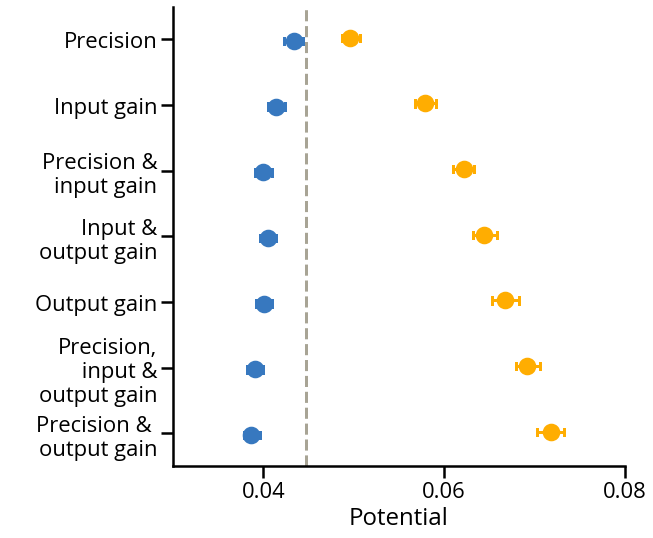

In [3]:
order = ['P-1_I-0_O-0.3','P-1_I-0.05_O-0.2', 'P-0_I-0_O-0.3','P-0_I-0.05_O-0.2','P-1_I-0.15_O-0', 'P-0_I-0.15_O-0', 'P-1_I-0_O-0']

mode = 'points_h'
if mode == 'bars':
    # make a bar plot with the average FR in Hz
    g = sns.catplot(x="Model", y="Potential", hue="Attention", data=evo_avgs[evo_avgs['Attention']!='neutral'],
                    height=8, aspect=2.2, kind="bar", palette={'valid': colors[0],'invalid': colors[1], 'neutral': colors[2] },
                    legend=False, order=order)
elif mode == 'points':
    dodge = True
    capsize = 0.1
    aspect = 1.85
    # amber, orange yellow

    g = sns.catplot(x="Model", y="Potential", hue="Attention", data=evo_avgs[evo_avgs['Attention']!='neutral'],
                    height=8, aspect=aspect, kind="point",
                    palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                    legend=False, zorder=6, order=order, join=False, dodge=dodge,
                    capsize=capsize, errwidth=3)

elif mode == 'points_h':
    dodge = True
    capsize = 0.1
    aspect = 1.2
    errwidth = 3
    order = ['P-1_I-0_O-0', 'P-0_I-0.15_O-0', 'P-1_I-0.15_O-0', 'P-0_I-0.05_O-0.2', 'P-0_I-0_O-0.3', 'P-1_I-0.05_O-0.2',
             'P-1_I-0_O-0.3']

    g = sns.catplot(y="Model", x="Potential", hue="Attention", data=evo_avgs[evo_avgs['Attention']!='neutral'],
                    height=8, aspect=aspect, kind="point",
                    palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                    legend=False, zorder=6, order=order, join=False, dodge=dodge,
                    capsize=capsize, errwidth=3, orient='h')

    g.set_yticklabels(['Precision', 'Input gain', 'Precision &\ninput gain','Input &\noutput gain','Output gain',
                       'Precision,\n input &\noutput gain','Precision & \noutput gain'])

    means = evo_avgs.groupby(['Attention']).mean()
    means = means.reset_index()
    mean = means.loc[means['Attention'] == 'neutral', 'Potential'].values


    limits = np.array([0.03, 0.08])
    plt.xlim(limits)
    g.ax.set_xticks([0.04, 0.06, 0.08])
    g.ax.set_xlabel('Potential')
    g.ax.set_ylabel(' ')
    g.ax.axvline(mean, c=colors[2], ls='--', zorder=0)

    plt.tight_layout()


    sns.despine(top=True, right=True)
    if save == True:
        g.savefig(figure_path + 'EvokedPotentials_' + mode + '.pdf', dpi=300, transparent=True)
    else:
        plt.show()
else:
    raise ValueError("Not implemented.")

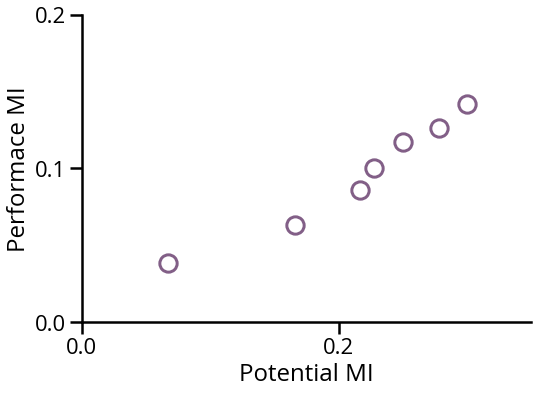

In [4]:
performance = pd.read_pickle(evaluation_path + 'Performance_150620_bootstrap.pkl')
means_AUC = performance.groupby(['Model', 'Attention']).mean().reset_index()
means = evo_avgs.groupby(['Model', 'Attention']).mean().reset_index()

AI = pd.DataFrame(np.zeros((len(order) - 1, 3)), columns=['Model', 'Evoked-AMI', 'Behaviour-AMI'])

for c, cond in enumerate(order):
    AI.loc[c, 'Model'] = cond
    validevo = means.loc[(means['Model'] == cond) & (means['Attention'] == 'valid'), 'Potential'].values
    invalidevo = means.loc[(means['Model'] == cond) & (means['Attention'] == 'invalid'), 'Potential'].values
    AI.loc[c, 'Evoked-AMI'] = (validevo - invalidevo) / (validevo + invalidevo)

    validAUC = means_AUC.loc[(means_AUC['Model'] == cond) & (means_AUC['Attention'] == 'valid'), 'Analog performance range'].values
    invalidAUC = means_AUC.loc[(means_AUC['Model'] == cond) & (means_AUC['Attention'] == 'invalid'), 'Analog performance range'].values
    AI.loc[c, 'Behaviour-AMI'] = (validAUC - invalidAUC) / (validAUC + invalidAUC)


fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(AI['Evoked-AMI'],AI['Behaviour-AMI'],c='white', edgecolor=colors[4], s=300, linewidths= 3)
ax.set_xlabel('Potential MI')
ax.set_ylabel('Performace MI')
ax.set_xlim([0,0.35])
ax.set_ylim([0,0.2])
ax.set_yticks([0,0.1, 0.2])
ax.set_xticks([0,0.2])
sns.despine()
plt.tight_layout()
if save == True:
    fig.savefig(figure_path + 'EvokedPotential_AMI_flat.pdf', dpi=300, transparent=True)
else:
    plt.show()


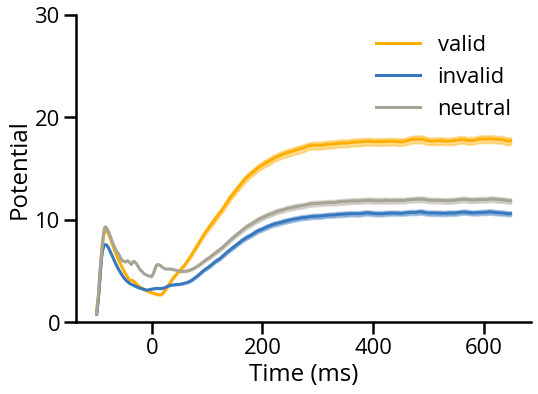

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
cond = 'P-0_I-0_O-0.3'

for a, att in enumerate(['valid', 'invalid', 'neutral']):
    if att == 'neutral':
        resp = tracker[l][att]['evoked'][:n, offset:]
        mean_draws = mean_draws_neutral

    else:
        resp = tracker[l][cond][att]['evoked'][:n, offset:]

        mean_draws = list()
        for d in range(num_draws):
            # Resampling, with replacement
            draw = resample(idx, random_state=d)
            mean_draws.append(np.mean(resp[draw], axis=0))

    ax.plot(time_steps, np.mean(resp, axis=0), color=colors[a], label=att)

    ax.fill_between(time_steps, np.percentile(np.array(mean_draws), 2.5, axis=0),
                    np.percentile(mean_draws, 97.5, axis=0),
                    color=colors[a], alpha=0.4)

sns.despine()
ax.set_ylim([0,30])
ax.set_xlabel('Time (ms)')
ax.set_yticks([0,10,20, 30])
ax.set_ylabel('Potential')
plt.legend(frameon=False)
plt.tight_layout()
if save == True:
    fig.savefig(figure_path + 'EvokedPotential_example_flat.pdf', dpi=300, transparent=True)
else:
    plt.show()

In [ ]:
# Statistical analysis, pairwise comparisons per condition
import random

comps = ['valid vs invalid', 'valid vs neutral', 'invalid vs neutral']
results = {}
results_df = pd.DataFrame([], columns=['Mechanism', 'Comparison', 'Difference', 'p-values', 'significant'])

# Define p (number of permutations):
p = 1000

results['Permutations'] = p
results['alpha-level'] = 0.05 / len(comps)
for cond in order:
    if cond not in results:
        results[cond] = {}
    print(cond)
    validPreds = evo_avgs.loc[(evo_avgs['Model']==cond) & (evo_avgs['Attention']=='valid'), 'Potential'].values
    invalidPreds = evo_avgs.loc[(evo_avgs['Model']==cond) & (evo_avgs['Attention']=='invalid'), 'Potential'].values
    neutralPreds = evo_avgs.loc[(evo_avgs['Model']==cond) & (evo_avgs['Attention']=='neutral'), 'Potential'].values
    idx = np.arange(len(validPreds) * 2)
    for comp in comps:
        if comp not in results[cond]:
            print(comp)
            if comp == 'valid vs invalid':
                diff = np.abs(np.mean(validPreds) - np.mean(invalidPreds))
                samplePreds = np.concatenate([validPreds, invalidPreds], axis=0)
            elif comp == 'valid vs neutral':
                diff = np.abs(np.mean(validPreds) - np.mean(neutralPreds))

                samplePreds = np.concatenate([validPreds, neutralPreds], axis=0)
            elif comp == 'invalid vs neutral':
                diff = np.abs(np.mean(invalidPreds) - np.mean(neutralPreds))

                samplePreds = np.concatenate([invalidPreds, neutralPreds], axis=0)
            else:
                raise ValueError('Comparison is not specified.')

            # Initialize permutation:
            pD = []

            # Permutation loop:
            for i in range(0, p):
                random.shuffle(idx)
                pD.append(np.abs(np.mean(samplePreds[idx[:int(len(idx)//2)]]) - np.mean(samplePreds[idx[int(len(idx) // 2):]])))

            p_val = len(np.where(pD>=diff)[0])/p
            print(cond + ': ' + str(p_val))

            results[cond][comp] = {}
            results[cond][comp]['Observed difference'] = diff
            results[cond][comp]['Difference distribution'] = pD
            results[cond][comp]['p-value']=p_val

            results_df = results_df.append({'Mechanism':cond, 'Comparison':comp, 'Difference':diff, 'p-values':p_val, 'significant':p_val<results['alpha-level']},ignore_index=True )


joblib.dump(results, result_path + 'EvokedPermutationTestsComparisons.pkl', compress=True)
results_df.to_csv(result_path + 'EvokedPermutationTestsComparisons_df.csv')

